In [1]:
import numpy as np
import pandas as pd
from sklift.datasets import fetch_hillstrom, clear_data_dir
import causalml
import econml
from econml.dml import DML, LinearDML, SparseLinearDML, CausalForestDML


In [2]:
from itertools import product
from sklearn.linear_model import (Lasso, LassoCV, LogisticRegression,
                                  LogisticRegressionCV,LinearRegression,
                                  MultiTaskElasticNet,MultiTaskElasticNetCV)
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, GradientBoostingRegressor, GradientBoostingClassifier
from sklearn.preprocessing import PolynomialFeatures
from lightgbm import LGBMRegressor, LGBMClassifier
import matplotlib.pyplot as plt
import matplotlib
from sklearn.model_selection import train_test_split

In [3]:
dataset = fetch_hillstrom(target_col='spend')
dataset.keys()

dict_keys(['data', 'target', 'treatment', 'DESCR', 'feature_names', 'target_name', 'treatment_name'])

In [4]:
view_table = dataset.data.copy()
view_table['promotion'] = dataset.treatment
view_table['sales 2weeks after promotion'] = dataset.target
view_table

,recency,history_segment,history,mens,womens,zip_code,newbie,channel,promotion,sales 2weeks after promotion
0,10,2) $100 - $200,142.44,1,0,Surburban,0,Phone,Womens E-Mail,0.0
1,6,3) $200 - $350,329.08,1,1,Rural,1,Web,No E-Mail,0.0
2,7,2) $100 - $200,180.65,0,1,Surburban,1,Web,Womens E-Mail,0.0
3,9,5) $500 - $750,675.83,1,0,Rural,1,Web,Mens E-Mail,0.0
4,2,1) $0 - $100,45.34,1,0,Urban,0,Web,Womens E-Mail,0.0
...,...,...,...,...,...,...,...,...,...,...
63995,10,2) $100 - $200,105.54,1,0,Urban,0,Web,Mens E-Mail,0.0
63996,5,1) $0 - $100,38.91,0,1,Urban,1,Phone,Mens E-Mail,0.0
63997,6,1) $0 - $100,29.99,1,0,Urban,1,Phone,Mens E-Mail,0.0
63998,1,5) $500 - $750,552.94,1,0,Surburban,1,Multichannel,Womens E-Mail,0.0


In [5]:
dataset.target

0        0.0
1        0.0
2        0.0
3        0.0
4        0.0
        ... 
63995    0.0
63996    0.0
63997    0.0
63998    0.0
63999    0.0
Name: spend, Length: 64000, dtype: float64

In [6]:
print(f"Dataset type: {type(dataset)}\n")
print(f"Dataset features shape: {dataset.data.shape}")
print(f"Dataset target shape: {dataset.target.shape}")
print(f"Dataset treatment shape: {dataset.treatment.shape}")

Dataset type: <class 'sklearn.utils._bunch.Bunch'>

Dataset features shape: (64000, 8)
Dataset target shape: (64000,)
Dataset treatment shape: (64000,)


In [7]:
def preprocess_data(df, treatment, target):

    df = df.drop(columns=['history', 'mens'])

    df = pd.get_dummies(df, columns=['history_segment'])

    df['zip_code'] = df['zip_code'].map({'Urban': 0, 'Surburban': 1, 'Rural': 2})
    df['channel'] = df['channel'].map({'Multichannel': 0, 'Phone': 1, 'Web': 2})

    treatment_filter = treatment.map({'No E-Mail': 0, 'Mens E-Mail': 1, 'Womens E-Mail': 2})
    df['Promotion'] = treatment_filter
    df['sales'] = target
    df = df[((df['womens'] == 1) & (df['Promotion'] == 2)) | ((df['womens'] == 0) & (df['Promotion'] == 1)) | (df['Promotion'] == 0)].reset_index(drop=True)
    df = df[df['sales'] < 200.0].reset_index(drop=True)

    return df[[col for col in df.columns if col not in ['Promotion', 'sales']]], df['Promotion'].replace(2, 1), df['sales']


dataset.data, dataset.treatment, dataset.target = preprocess_data(dataset.data, dataset.treatment, dataset.target)

In [8]:
lgb_Y_params = {
    'objective': 'regression',
    'metric': 'mse',
    'boosting_type': 'gbdt',
    'num_leaves': 51,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': -1
}

lgb_T_params = {
    'objective': 'binary',
    'metric': 'auc',
    'boosting_type': 'gbdt',
    'num_leaves': 51,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': -1

}

cfdml = CausalForestDML(model_y=LGBMRegressor(**lgb_Y_params),
                       model_t=LGBMClassifier(**lgb_T_params),
                       criterion='mse', n_estimators=1000, cv=3, n_jobs=18,
                       min_impurity_decrease=0.0001, min_samples_leaf=25,
                       random_state=7113, discrete_treatment=True)

In [9]:
train_df, test_df, train_y, test_y, train_t, test_t = train_test_split(dataset.data, dataset.target, dataset.treatment, test_size=0.25, random_state=7113)

In [10]:
train_df

,recency,womens,zip_code,newbie,channel,history_segment_1) $0 - $100,history_segment_2) $100 - $200,history_segment_3) $200 - $350,history_segment_4) $350 - $500,history_segment_5) $500 - $750,"history_segment_6) $750 - $1,000","history_segment_7) $1,000 +"
20326,6,0,0,1,1,0,0,1,0,0,0,0
7535,1,1,0,1,0,0,0,0,1,0,0,0
33791,1,1,1,1,1,0,0,0,0,0,0,1
23380,3,0,1,0,2,1,0,0,0,0,0,0
9158,5,0,2,0,2,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
34655,6,0,1,0,1,0,1,0,0,0,0,0
39604,9,0,0,1,1,0,1,0,0,0,0,0
28937,11,0,2,1,2,1,0,0,0,0,0,0
26484,7,0,2,1,1,0,0,1,0,0,0,0


In [11]:
train_t

20326    0
7535     1
33791    0
23380    1
9158     0
        ..
34655    1
39604    1
28937    1
26484    0
25343    0
Name: Promotion, Length: 31932, dtype: int64

<Axes: >

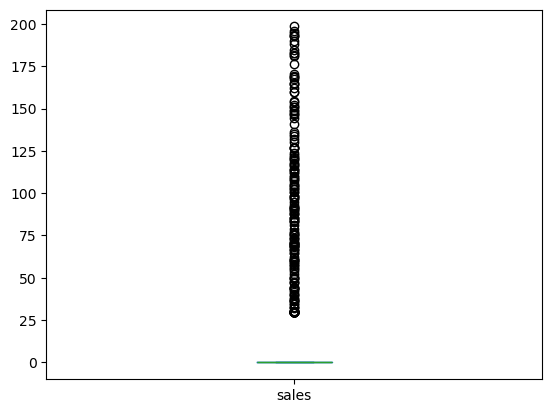

In [12]:
train_y.plot.box()

In [13]:
train_df

,recency,womens,zip_code,newbie,channel,history_segment_1) $0 - $100,history_segment_2) $100 - $200,history_segment_3) $200 - $350,history_segment_4) $350 - $500,history_segment_5) $500 - $750,"history_segment_6) $750 - $1,000","history_segment_7) $1,000 +"
20326,6,0,0,1,1,0,0,1,0,0,0,0
7535,1,1,0,1,0,0,0,0,1,0,0,0
33791,1,1,1,1,1,0,0,0,0,0,0,1
23380,3,0,1,0,2,1,0,0,0,0,0,0
9158,5,0,2,0,2,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
34655,6,0,1,0,1,0,1,0,0,0,0,0
39604,9,0,0,1,1,0,1,0,0,0,0,0
28937,11,0,2,1,2,1,0,0,0,0,0,0
26484,7,0,2,1,1,0,0,1,0,0,0,0


In [14]:
control_feats = ['womens', 'zip_code']
heterogeneity_feats = [col for col in train_df.columns if col not in control_feats]

In [15]:
cfdml.tune(train_y, train_t, X=train_df[heterogeneity_feats], W=train_df[control_feats])
cfdml.fit(train_y, train_t, X=train_df[heterogeneity_feats], W=train_df[control_feats])
te_pred = cfdml.effect(test_df[heterogeneity_feats])

In [16]:
cfdml.score_

64.65932495988909

In [17]:
cfdml.score(test_y, test_t, X=test_df[heterogeneity_feats], W=test_df[control_feats])

50.868670962897816

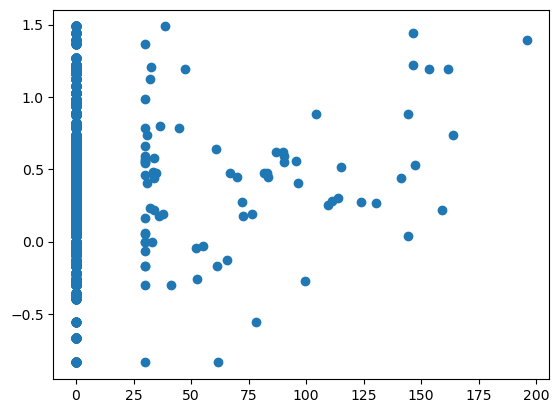

In [18]:
plt.scatter(test_y, te_pred, label='CausalForestDML: Predicted vs True treatment effect')

In [19]:
from econml.cate_interpreter import SingleTreeCateInterpreter, SingleTreePolicyInterpreter

In [20]:
intrp = SingleTreePolicyInterpreter(include_model_uncertainty=True, max_depth=4, min_samples_leaf=100, random_state=7113)
intrp.interpret(cfdml, train_df[heterogeneity_feats], sample_treatment_costs=0.17)

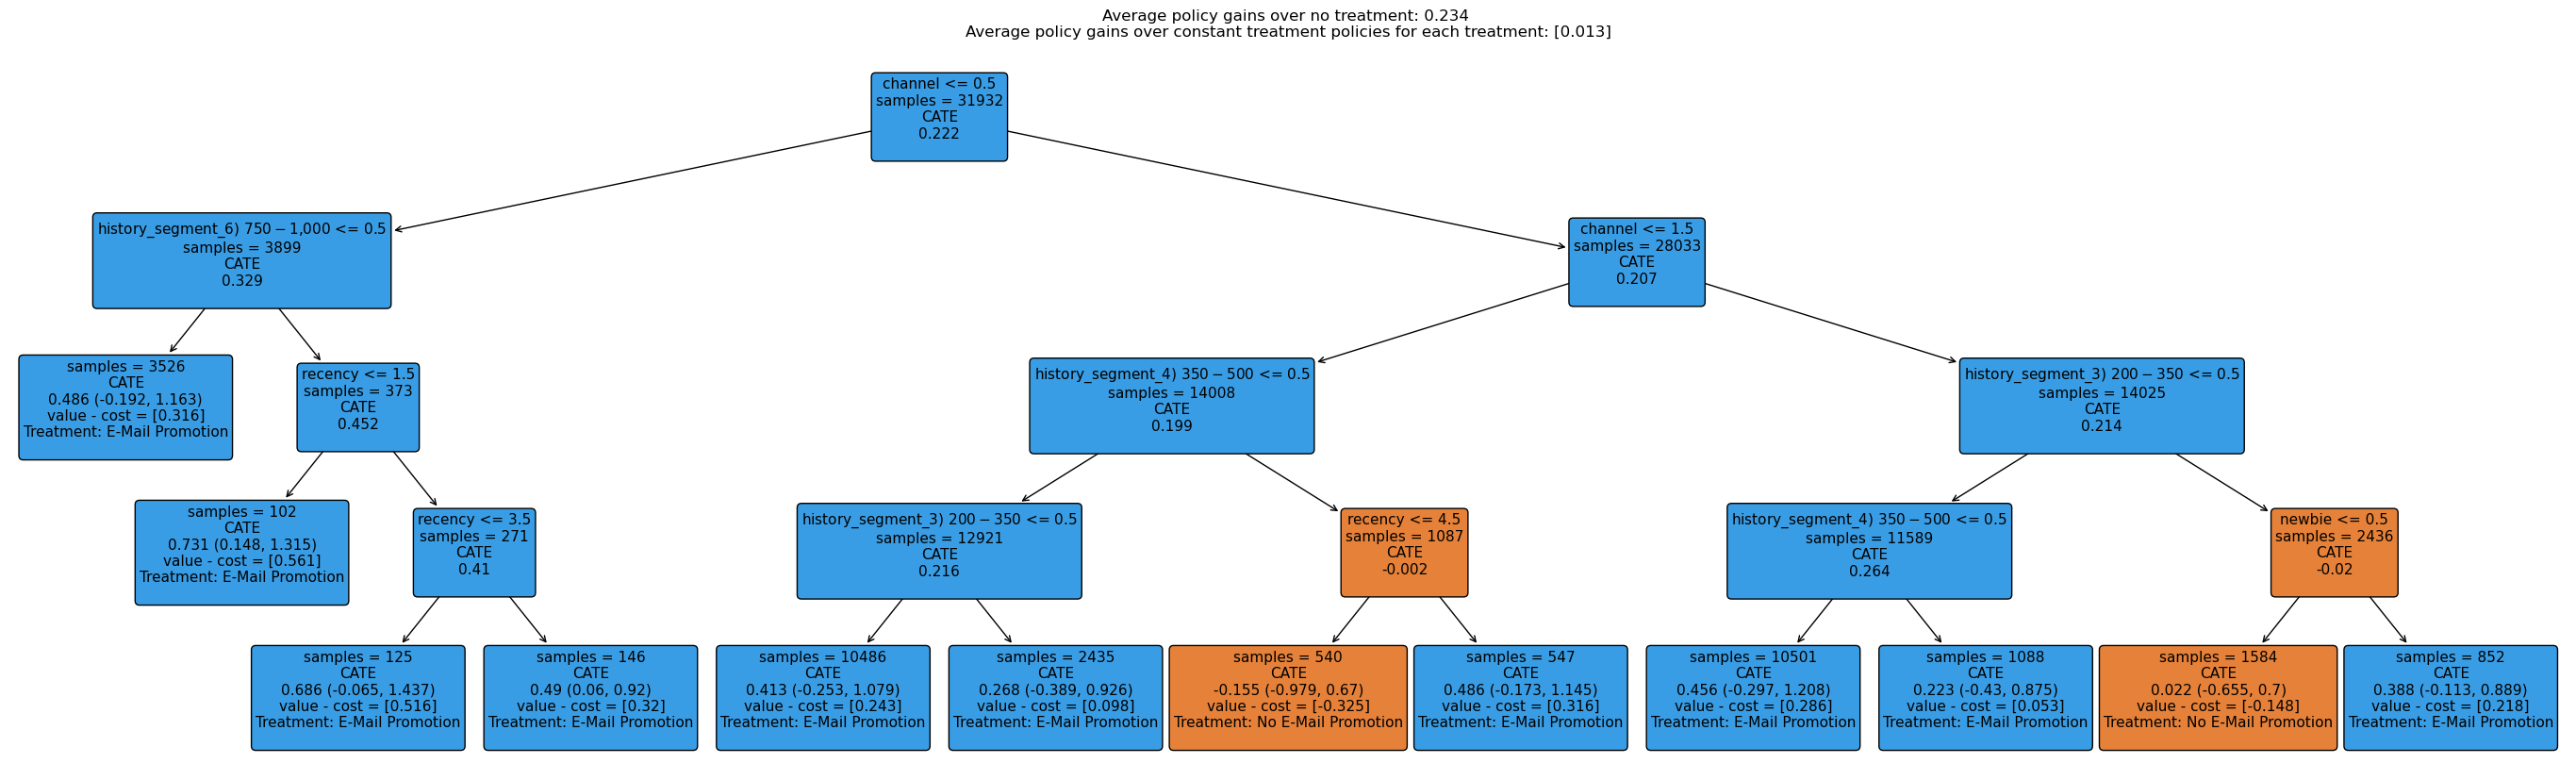

In [21]:
plt.figure(figsize=(35, 10))
intrp.plot(feature_names=heterogeneity_feats, treatment_names=['No E-Mail Promotion', 'E-Mail Promotion'], fontsize=11)
plt.show()

In [22]:
intrp = SingleTreeCateInterpreter(include_model_uncertainty=True, max_depth=4, min_samples_leaf=100, random_state=7113)
intrp.interpret(cfdml, train_df[heterogeneity_feats])

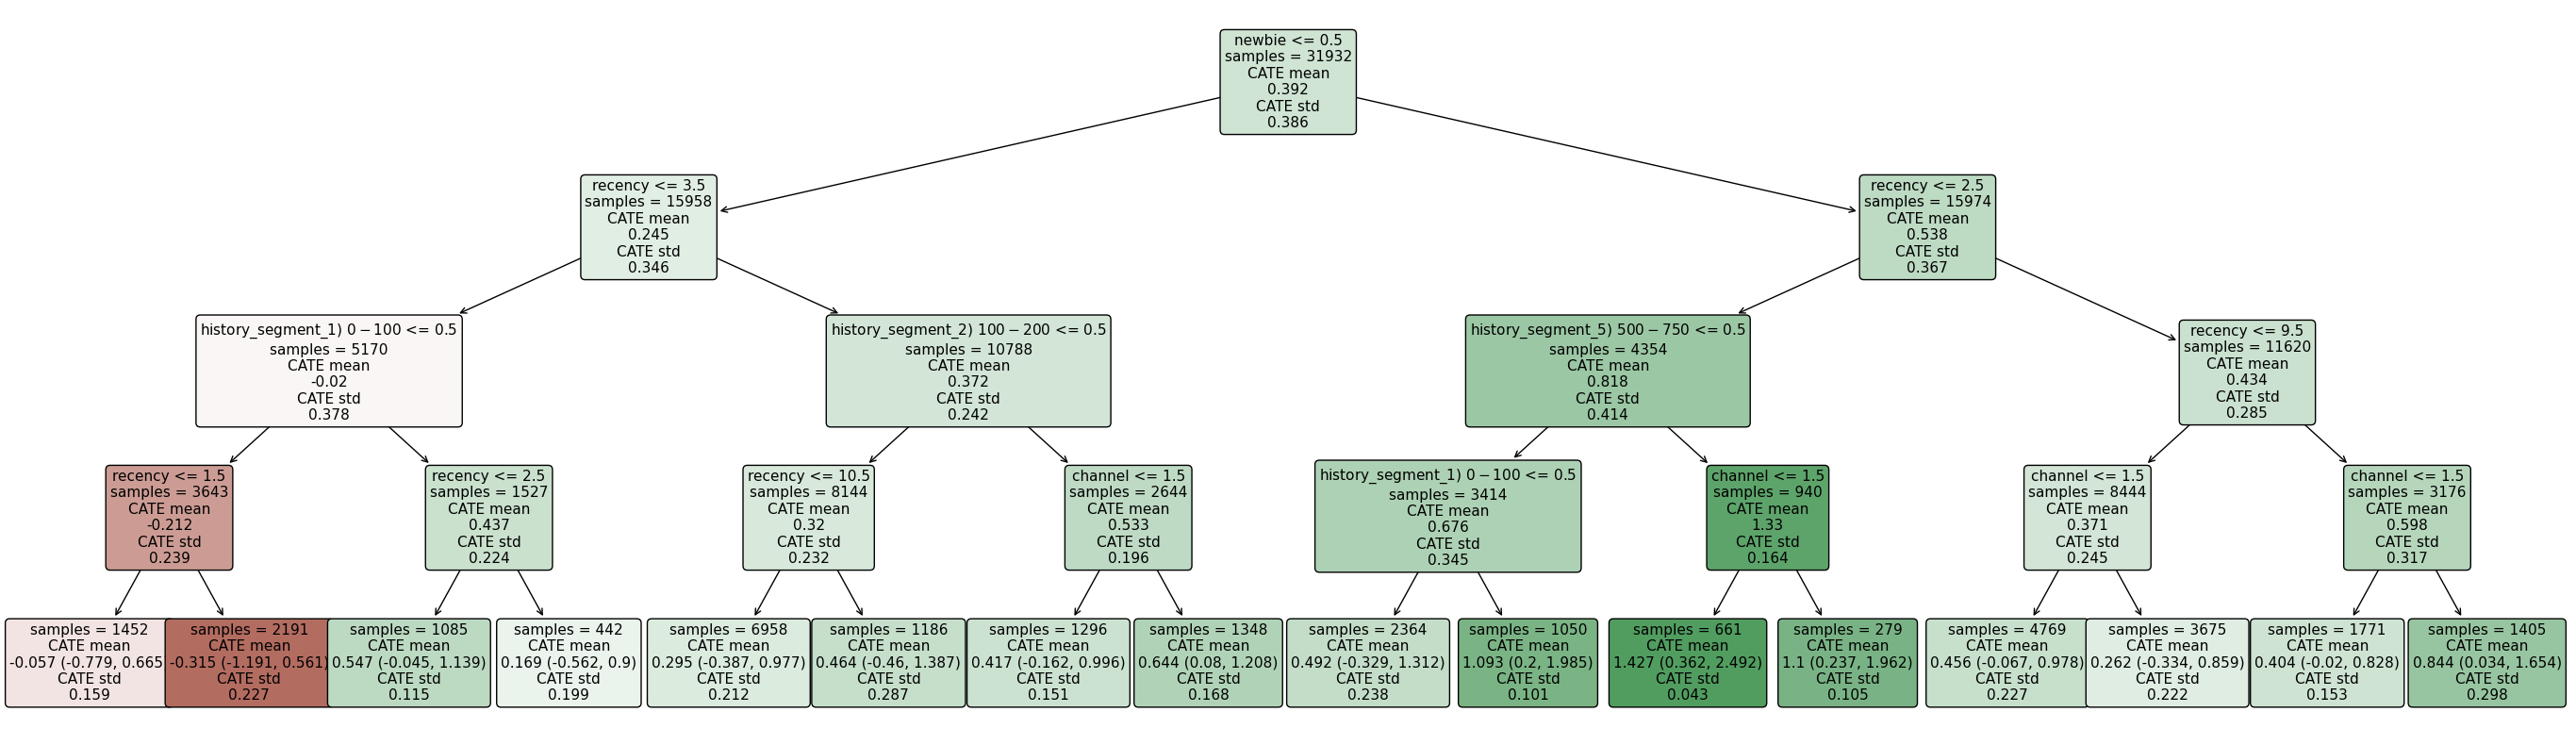

In [23]:
plt.figure(figsize=(35, 10))
intrp.plot(feature_names=heterogeneity_feats, treatment_names=['No E-Mail', 'E-Mail Promotion'], fontsize=11)
plt.show()

In [24]:
import shap

In [25]:
shap_values = cfdml.shap_values(train_df[heterogeneity_feats])

100%|===================| 31909/31932 [14:38<00:00]        

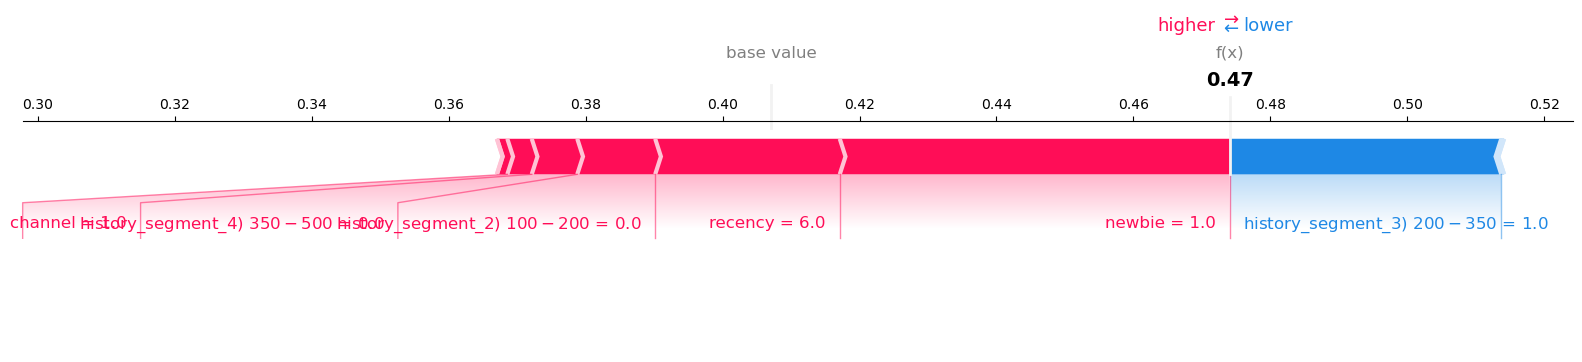

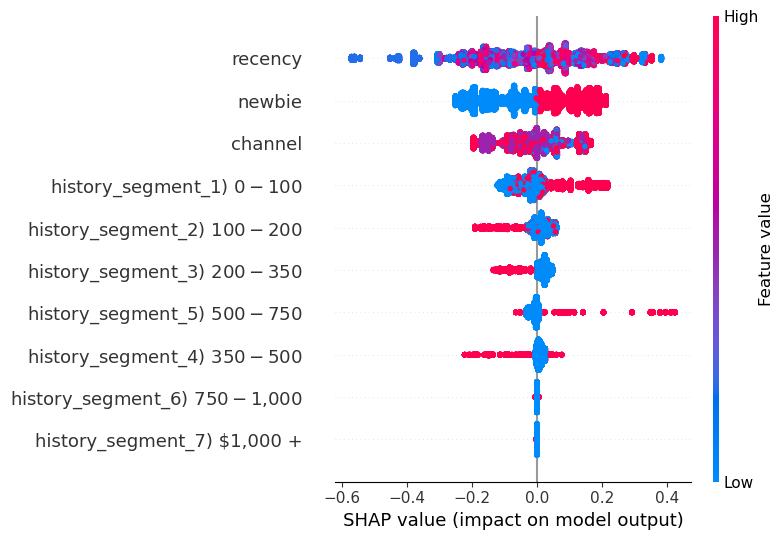

In [26]:
ind=0
shap.plots.force(shap_values["sales"]["Promotion_1"][ind], matplotlib=True)
# global view: explain hetergoeneity for a sample of dataset
shap.summary_plot(shap_values["sales"]["Promotion_1"])

In [27]:
cfdml.summary()

Population summary results are available only if `cache_values=True` at fit time!


,point_estimate,stderr,zstat,pvalue,ci_lower,ci_upper
ATE,0.381,0.091,4.175,0.0,0.202,0.56
,point_estimate,stderr,zstat,pvalue,ci_lower,ci_upper
ATT,0.352,0.107,3.286,0.001,0.142,0.563
,point_estimate,stderr,zstat,pvalue,ci_lower,ci_upper
ATT,0.41,0.148,2.773,0.006,0.12,0.701


In [28]:
potential_roi = cfdml.const_marginal_effect(test_df[heterogeneity_feats])
potential_roi = np.hstack([np.zeros((test_df[heterogeneity_feats].values.shape[0], 1)), potential_roi]) - 0.17
all_treatments = np.array(['No E-Mail', 'E-Mail Promotion'])
recommended_T = np.argmax(potential_roi, axis=1)
roi_current = potential_roi[np.arange(test_df.shape[0]), test_t].sum()
roi_optimal = potential_roi[np.arange(test_df.shape[0]), recommended_T].sum()
#roi_bothT = potential_roi[:, -1].sum()
all_rois = np.array([roi_current, roi_optimal])
#Y_baseline = (test_y - cfdml.effect(X=test_df[heterogeneity_feats].values, T1=test_t)).sum()
pd.DataFrame(
    {
        "Policy": ["Current Promotion Strategy", "AI Assisted Promotion Strategy"],
        "ROI ($)": all_rois,
        #"ROI (% of baseline Y)": np.round(all_rois / Y_baseline * 100, 1),
    }
)

,Policy,ROI ($)
0,Current Promotion Strategy,302.380864
1,AI Assisted Promotion Strategy,2717.695332
